<a href="https://colab.research.google.com/github/meiqingli/Geospatial-Software-Design/blob/master/D_Lab_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Extracting Time-Series Satellite Images with Google Earth Engine Python API

by: Meiqing Li (meiqing@berkeley.edu), D-Lab Data Science Fellow

This notebook demonstrates the process to filter, classify, resample, and visualiza time-series satellite images using Google Earth Engine Python API.

### API Setup: import, authenticate and initialize

Beofre running the code, we need to first import the Google Earth Enginer API. Since the Earth Engine API is installed by default in Google Colaboratory, I don't need to install it here.

In [4]:
import ee

This will trigger the authentication flow of Google Earth Engine. We will follow the url, which will bring us to the authentication steps. Copy and paste the provided token. Once it is successfullly authorized, we can proceed with our analysis.

In [8]:
# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize(project='ee-meiqingli')

### Explore Earth Engine Data Catalog

There are a lot of things we can explore wih Google Earth Engine. [The Earth Engine Data Catalog](https://developers.google.com/earth-engine/datasets/catalog) has a collection of public raster datasets which we can import directly to our projects by referring to the "Earth Engine Snippet". The two datasets we will use for this notebook are: 1)[CCNL: Consistent And Corrected Nighttime Light Dataset from DMSP-OLS (1992-2013)](https://developers.google.com/earth-engine/datasets/catalog/BNU_FGS_CCNL_v1); 2)[VIIRS Stray Light Corrected Nighttime Day/Night Band Composites Version 1](https://developers.google.com/earth-engine/datasets/catalog/NOAA_VIIRS_DNB_MONTHLY_V1_VCMSLCFG#description).

##### DMSP/OLS



In [9]:
## import DMSP OLS Nighttime Lights (1992-01-01 - 2014-01-01)
# select band and filter date
DMSP = ee.ImageCollection('BNU/FGS/CCNL/v1').select('b1').filterDate('1992-01-01', '2014-01-01')

##### VIIRS

In [10]:
## import VIIRS Nighttime Lights (2014-01-01 - 2022-11-01)
# select band and filter date
VIIRS = ee.ImageCollection('NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG').select('avg_rad').filterDate('2014-01-01', '2022-01-01')

### Import Features

We can also [upload](https://developers.google.com/earth-engine/guides/table_upload) our own feature tables to Google Earth Engine, and import to our project. Here I import the California county and state boundaries which were uploaded from shapefiles.


In [11]:
# I have uploaded CA county and state boundaries through GEE console (add more description here)
# import features
CACounty = ee.FeatureCollection("projects/spherical-depth-278922/assets/California_County_Boundaries")
CAState = ee.FeatureCollection("projects/ee-meiqingli/assets/CAState")

### Get time-series data for a location

We can get the time-series data around a selected location. For example, the coordinate for UC Berkeley is [37.8719, -122.2585]. We can use `.getRegion()` to calculate the average nighttime light intensity across years around UC Berkeley from both DMSP/OLS and VIIRS datasets.



In [12]:
## Calculate the mean value around a location using the `getRegion()` method
# DMSP/OLS
poi = ee.Geometry.Point([-122.3790, 37.6213]) # note [lon, lat]
scale = 30

DMSP_poi = DMSP.getRegion(poi, scale).getInfo()

# preview the result
DMSP_poi[:5]

[['id', 'longitude', 'latitude', 'time', 'b1'],
 ['DMSP1992v1',
  -122.37897337582122,
  37.621309351632945,
  694224000000,
  67.76784695621606],
 ['DMSP1993v1',
  -122.37897337582122,
  37.621309351632945,
  725846400000,
  56.66487062392774],
 ['DMSP1994v1',
  -122.37897337582122,
  37.621309351632945,
  757382400000,
  81.95031347136096],
 ['DMSP1995v1',
  -122.37897337582122,
  37.621309351632945,
  788918400000,
  91.53101235005826]]

In [13]:
# VIIRS
VIIRS_poi = VIIRS.getRegion(poi, scale).getInfo()

# preview the result
VIIRS_poi[:5]

[['id', 'longitude', 'latitude', 'time', 'avg_rad'],
 ['20140101',
  -122.37897337582122,
  37.621309351632945,
  1388534400000,
  55.463462829589844],
 ['20140201',
  -122.37897337582122,
  37.621309351632945,
  1391212800000,
  72.19701385498047],
 ['20140301',
  -122.37897337582122,
  37.621309351632945,
  1393632000000,
  60.484066009521484],
 ['20140401',
  -122.37897337582122,
  37.621309351632945,
  1396310400000,
  63.16453170776367]]

To make it easier to access the data, we transform the time-series data into pandas dataframes and convert time to datetime format.

In [14]:
import pandas as pd

def ee_array_to_df(arr, list_of_bands):
    """Transforms client-side ee.Image.getRegion array to pandas.DataFrame."""
    df = pd.DataFrame(arr)

    # Rearrange the header.
    headers = df.iloc[0]
    df = pd.DataFrame(df.values[1:], columns=headers)

    # Remove rows without data inside.
    df = df[['longitude', 'latitude', 'time', *list_of_bands]].dropna()

    # Convert the data to numeric values.
    for band in list_of_bands:
        df[band] = pd.to_numeric(df[band], errors='coerce')

    # Convert the time field into a datetime.
    df['datetime'] = pd.to_datetime(df['time'], unit='ms')

    # Keep the columns of interest.
    df = df[['time','datetime',  *list_of_bands]]

    return df

In [15]:
# select band of interest
dmsp_poi = ee_array_to_df(DMSP_poi,['b1'])
viirs_poi = ee_array_to_df(VIIRS_poi,['avg_rad'])

viirs_poi.head()

,time,datetime,avg_rad
0,1388534400000,2014-01-01,55.463463
1,1391212800000,2014-02-01,72.197014
2,1393632000000,2014-03-01,60.484066
3,1396310400000,2014-04-01,63.164532
4,1398902400000,2014-05-01,52.005966


Once we have the time-series data, we can plot them on a scatter plot to examine the longitudinal change in nighttime light intensity around UC Berkeley, as well as the variation across two datasets.

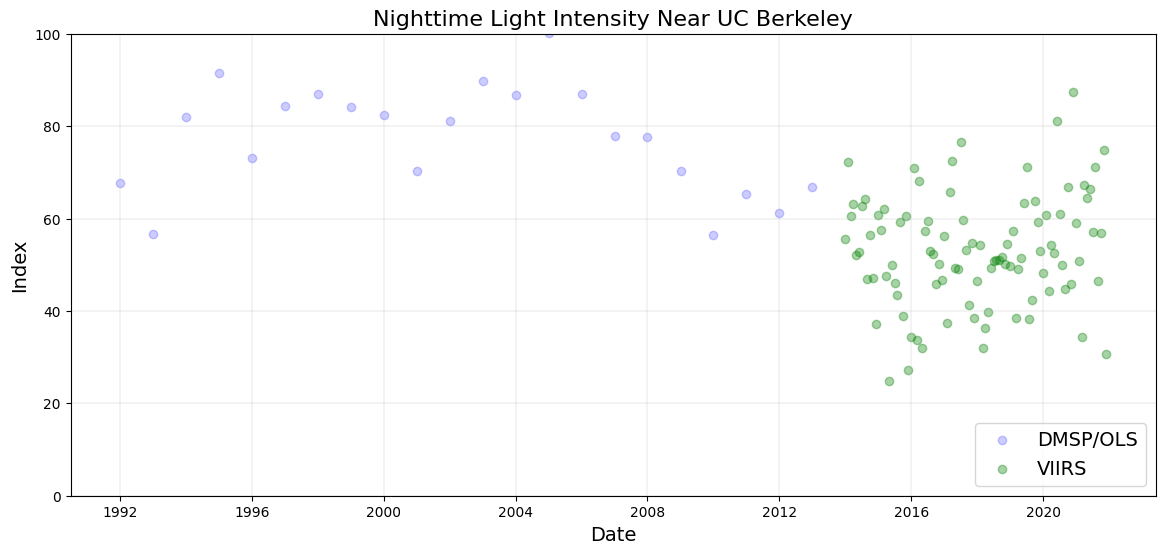

In [16]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Fitting curves.
## First, extract x values (times) from the dfs.
x_data_u = np.asanyarray(dmsp_poi['time'].apply(float))
x_data_r = np.asanyarray(viirs_poi['time'].apply(float))

## Secondly, extract y values (LST) from the dfs.
y_data_u = np.asanyarray(dmsp_poi['b1'].apply(float))
y_data_r = np.asanyarray(viirs_poi['avg_rad'].apply(float))

# Subplots.
fig, ax = plt.subplots(figsize=(14, 6))

# Add scatter plots.
ax.scatter(dmsp_poi['datetime'], dmsp_poi['b1'],
           c='blue', alpha=0.2, label='DMSP/OLS')
ax.scatter(viirs_poi['datetime'], viirs_poi['avg_rad'],
           c='green', alpha=0.35, label='VIIRS')


# Add some parameters.
ax.set_title('Nighttime Light Intensity Near UC Berkeley', fontsize=16)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Index', fontsize=14)
ax.set_ylim(0, 100)
ax.grid(lw=0.2)
ax.legend(fontsize=14, loc='lower right')

plt.show()

## Static image

We can also extract the average values from a certain region. In this example, I filter the data by Alameda County, and visualize them in a customized color palette. Comparing the two thumbnails using DMSP/OLS and VIIRS, the latter has a higher resolution and less overcast.

In [17]:
# filter county boundary by name, get geometry
alameda = CACounty.filterMetadata("COUNTY_NAM","equals", "Alameda").first().geometry()

In [18]:
# Import the Image function from the IPython.display module.
from IPython.display import Image

# Display a thumbnail of global nighttime light.
Image(url = DMSP.mean()
  .getThumbURL({'min': 0, 'max': 63, 'region': alameda, 'dimensions': 512,
                'palette': ['000044','ffff00','ffffff']}))

In [20]:
# Display a thumbnail of global nighttime light.
Image(url = VIIRS.mean()
  .getThumbURL({'min': 0, 'max': 63, 'region': alameda, 'dimensions': 512,
                'palette': ['000044','ffff00','ffffff']}))

### Export a GEOTIFF file

Once we have the static image, we can save it as a GEOTIFF file to Google Drive.

In [21]:
VIIRS_img = VIIRS.mean()
DMSP_img = DMSP.mean()

task = ee.batch.Export.image.toDrive(image=VIIRS_img,
                                     description='night light intensity in Aladema',
                                     scale=30,
                                     region=alameda,
                                     fileNamePrefix='VIIRS_alameda',
                                     crs='EPSG:4326',
                                     fileFormat='GeoTIFF')
task.start()

In [22]:
task.status()

{'state': 'READY',
 'description': 'night light intensity in Aladema',
 'priority': 100,
 'creation_timestamp_ms': 1712550091297,
 'update_timestamp_ms': 1712550091297,
 'start_timestamp_ms': 0,
 'task_type': 'EXPORT_IMAGE',
 'id': '4Q3YE6OXLBOT5HH5HXZESAVU',
 'name': 'projects/ee-meiqingli/operations/4Q3YE6OXLBOT5HH5HXZESAVU'}

Or, we can get a link to download the GEOTIFF file.

In [23]:
link = VIIRS_img.getDownloadURL({
    'scale': 30,
    'crs': 'EPSG:4326',
    'fileFormat': 'GeoTIFF',
    'region': alameda})
print(link)

https://earthengine.googleapis.com/v1/projects/ee-meiqingli/thumbnails/022c413565f3aefe4897931e417c48db-b97bd23dd6a76c7a2978064139f91f10:getPixels


## Interactive map

Our final step is to map the global nighttime light data onto an interactive map. Toggle between DMSP and VIIRS layers by clicking checkboxes on the top right.

In [24]:
# Import the Folium library.
import folium

# Define a method for displaying Earth Engine image tiles to folium map.
def add_ee_layer(self, ee_image_object, vis_params, name):
  map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
  folium.raster_layers.TileLayer(
    tiles = map_id_dict['tile_fetcher'].url_format,
    attr = 'Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    name = name,
    overlay = True,
    control = True
  ).add_to(self)

# Add EE drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

# Set visualization parameters.
vis_params = {
  'min': 0,
  'max': 63,
  'palette': ['000044','ffff00','ffffff']}

# Create a folium map object. Zoom to California
my_map = folium.Map(location=[38, -121], zoom_start=5.5)

# Arrange layers inside a list
ee_tiles = [DMSP_img, VIIRS_img]

# Arrange visualization parameters inside a list.
ee_vis_params = [vis_params, vis_params]

# Arrange layer names inside a list.
ee_tiles_names = ['DMSP', 'VIIRS']

# Add layers to the map using a loop.
for tile, vis_param, name in zip(ee_tiles, ee_vis_params, ee_tiles_names):
    my_map.add_ee_layer(tile, vis_param, name)

folium.LayerControl(collapsed = False).add_to(my_map)


# Display the map.
display(my_map)

## References

*  [EE API Colab Setup](https://colab.research.google.com/github/google/earthengine-api/blob/master/python/examples/ipynb/ee-api-colab-setup.ipynb)
*   [EE Python API Tutorial](https://colab.research.google.com/github/google/earthengine-community/blob/master/tutorials/intro-to-python-api/index.ipynb)

* More tutorials: [Geemap package for interative mapping with GEE](https://github.com/gee-community/geemap)
